# Part 1: Binary Classication with PyTorch

In [13]:
# Import torch
import torch
from torch import nn

# Setup just device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

## 1. Make binary classification with sci-kit learn make_moon() function

In [9]:
# Create a dataset make_moons()
from sklearn.datasets import make_moons
n_samples = 1000

X,y = make_moons(n_samples,
                 noise = 0.07,
                 random_state = 42)

In [10]:
# Turn data into a pandas dataframe
import pandas as pd

moons = pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})

moons

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
...,...,...,...
995,0.803092,0.554727,0
996,-0.152207,0.936422,0
997,1.671254,-0.324041,1
998,-0.953016,0.302205,0


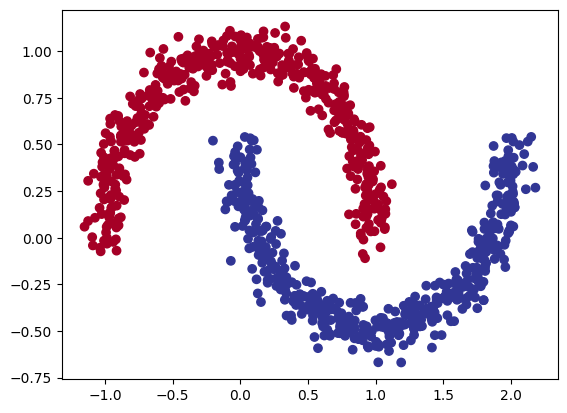

In [11]:
# Visualize the data with a scatter plot
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu)
plt.show()

In [12]:
# Turn data into tensors of dtype float
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

# Split data into train and test sets (80-20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

len(X_train), len(X_test)

(800, 200)

## 2. Build a model that incorporates non-linear activation functions

In [20]:
class MoonModelV0(nn.Module):
  def __init__(self, input_features:int, hidden_units:int, output_features:int):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self,x):
    return self.layers(x)

# Instantiate the model
model_0 = MoonModelV0(input_features = 2,
                     hidden_units = 10,
                     output_features = 1).to(device)

model_0.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-0.4190, -0.2781],
                      [ 0.1289,  0.2416],
                      [-0.1954,  0.2310],
                      [-0.1371,  0.3320],
                      [ 0.4286, -0.6299],
                      [ 0.5710,  0.6536],
                      [ 0.2731,  0.6472],
                      [-0.4628,  0.6362],
                      [ 0.5732, -0.6858],
                      [ 0.0634,  0.2818]])),
             ('layers.0.bias',
              tensor([ 0.0838,  0.4553, -0.4213,  0.0673,  0.6180, -0.6883,  0.3844,  0.3834,
                      -0.0388, -0.2447])),
             ('layers.2.weight',
              tensor([[-0.2919, -0.2150,  0.2740, -0.1652,  0.2980,  0.1192, -0.0578,  0.1813,
                        0.1223,  0.1916],
                      [ 0.2721, -0.1181,  0.1681, -0.2432,  0.2377, -0.2053, -0.1539,  0.1290,
                        0.2297, -0.1748],
                      [ 0.2325, -0.0240, -0.1255, -0.2107, -0.1290,  

## 3. Setup loss function and optimizer

In [21]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

## 4. Building and training and testing loop

In [22]:
# Logits -> Prediction Probabilites -> Prediction labels

# logits (raw output)
print("Logits: ")
y_logits = model_0(X_train.to(device)[:10]).squeeze()
print(y_logits)

# Prediction Probabilities
print("Pred probs")
y_pred = torch.sigmoid(y_logits)
print(y_pred)

# Prediction labels
print("Pred labels")
y_pred_probs = torch.round(y_pred)
print(y_pred_probs)

Logits: 
tensor([-0.4357, -0.3412, -0.1651, -0.1706, -0.3041, -0.1840, -0.3407, -0.2510,
        -0.1870, -0.3644], grad_fn=<SqueezeBackward0>)
Pred probs
tensor([0.3928, 0.4155, 0.4588, 0.4575, 0.4246, 0.4541, 0.4156, 0.4376, 0.4534,
        0.4099], grad_fn=<SigmoidBackward0>)
Pred labels
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<RoundBackward0>)


In [23]:
# Calcualte the accuracy using accuracy from torchmetrics
!pip -q install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task = "Multiclass", num_classes = 2).to(device)
acc_fn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 7.8 MB/s eta 0:00:00


MulticlassAccuracy()

In [24]:
# Traing and testing loops

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()

  # Logits -> Pred probs
  y_pred_prob = torch.sigmoid(y_logits)

  # Pred probs -> Pred labels
  y_pred = torch.round(y_pred_prob)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)

  # Accuracy
  acc = acc_fn(y_pred, y_train.int()) # accuracy function need to compare pred labels with actual labels

  # 3. Zero the optimzier grad
  optimizer.zero_grad()

  # 4. Loss Backward (Backpropagation)
  loss.backward()

  # 5. Optimizer step (Gradient Descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()

    # Turn test logits into pred labels
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  # Print out what is happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .4f} | | Acc: {acc: .2f} | Test Loss: {test_loss: .4f} | Test Acc: {test_acc: .2f}")


Epoch: 0 | Loss:  0.7377 | | Acc:  0.50 | Test Loss:  0.7298 | Test Acc:  0.50
Epoch: 100 | Loss:  0.2780 | | Acc:  0.87 | Test Loss:  0.2856 | Test Acc:  0.86
Epoch: 200 | Loss:  0.2354 | | Acc:  0.89 | Test Loss:  0.2327 | Test Acc:  0.90
Epoch: 300 | Loss:  0.2192 | | Acc:  0.90 | Test Loss:  0.2135 | Test Acc:  0.90
Epoch: 400 | Loss:  0.1972 | | Acc:  0.91 | Test Loss:  0.1902 | Test Acc:  0.92
Epoch: 500 | Loss:  0.1650 | | Acc:  0.93 | Test Loss:  0.1574 | Test Acc:  0.94
Epoch: 600 | Loss:  0.1245 | | Acc:  0.95 | Test Loss:  0.1172 | Test Acc:  0.95
Epoch: 700 | Loss:  0.0854 | | Acc:  0.97 | Test Loss:  0.0786 | Test Acc:  0.99
Epoch: 800 | Loss:  0.0564 | | Acc:  0.99 | Test Loss:  0.0507 | Test Acc:  0.99
Epoch: 900 | Loss:  0.0386 | | Acc:  0.99 | Test Loss:  0.0341 | Test Acc:  1.00


## 5. Make prediction with your trained model and plot using `plot_decision_boundary()`

In [25]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

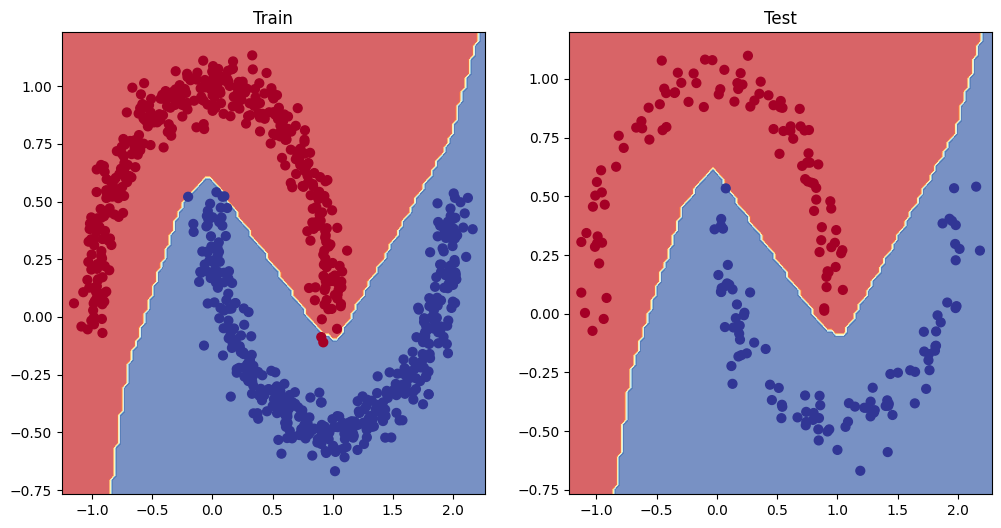

In [26]:
# Plot the decision boundary for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Part 2: Mult-class Classification with PyTorch

## 1. Get data

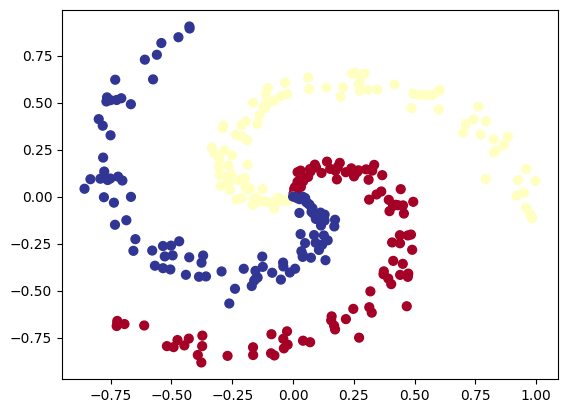

In [38]:
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

# Source for creation of dataset: https://madewithml.com/courses/foundations/neural-networks/

# 2. Turn data into tensors and split data into train and test

In [39]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 42)

In [46]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: uncomment the two lines below to send the accuracy function to the device
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

MulticlassAccuracy()

## 3. Build Model

In [40]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MoonModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features = 2, out_features = 10),
        nn.ReLU(),
        nn.Linear(in_features = 10, out_features = 10),
        nn.ReLU(),
        nn.Linear(in_features = 10, out_features = 3)
    )

  def forward(self,x):
    return self.layers(x)

# Instantiate model and send it to device
model_1 = MoonModelV1().to(device)
model_1

MoonModelV1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [41]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
logits = model_1(X_train[:10])

y_pred_probs = torch.softmax(logits, dim=1)

y_pred = torch.argmax(y_pred_probs, dim=1)

logits , y_pred_probs, y_pred

(tensor([[-0.3621, -0.2138, -0.2310],
         [-0.3614, -0.2079, -0.2221],
         [-0.3471, -0.2292, -0.2296],
         [-0.2831, -0.2908, -0.2104],
         [-0.2988, -0.2787, -0.2243],
         [-0.3317, -0.2429, -0.2223],
         [-0.3408, -0.2369, -0.2274],
         [-0.3587, -0.2284, -0.2479],
         [-0.3358, -0.2374, -0.2223],
         [-0.2822, -0.2918, -0.2104]], grad_fn=<AddmmBackward0>),
 tensor([[0.3030, 0.3515, 0.3455],
         [0.3016, 0.3517, 0.3467],
         [0.3077, 0.3462, 0.3461],
         [0.3260, 0.3235, 0.3506],
         [0.3228, 0.3294, 0.3478],
         [0.3117, 0.3406, 0.3477],
         [0.3096, 0.3435, 0.3468],
         [0.3071, 0.3498, 0.3431],
         [0.3102, 0.3423, 0.3475],
         [0.3263, 0.3232, 0.3506]], grad_fn=<SoftmaxBackward0>),
 tensor([1, 1, 1, 2, 2, 2, 2, 1, 2, 2]))

## 4. Create loss and optimizer functions

In [42]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.01)

## 5. Building training and testing loop

In [47]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. Forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():\
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.11 Acc: 0.20 | Test loss: 1.11 Test acc: 0.27
Epoch: 100 | Loss: 0.33 Acc: 0.85 | Test loss: 0.32 Test acc: 0.85
Epoch: 200 | Loss: 0.09 Acc: 0.98 | Test loss: 0.06 Test acc: 1.00
Epoch: 300 | Loss: 0.05 Acc: 0.99 | Test loss: 0.02 Test acc: 1.00
Epoch: 400 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 500 | Loss: 0.03 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 600 | Loss: 0.03 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


## 6. Plotting / Evaluation

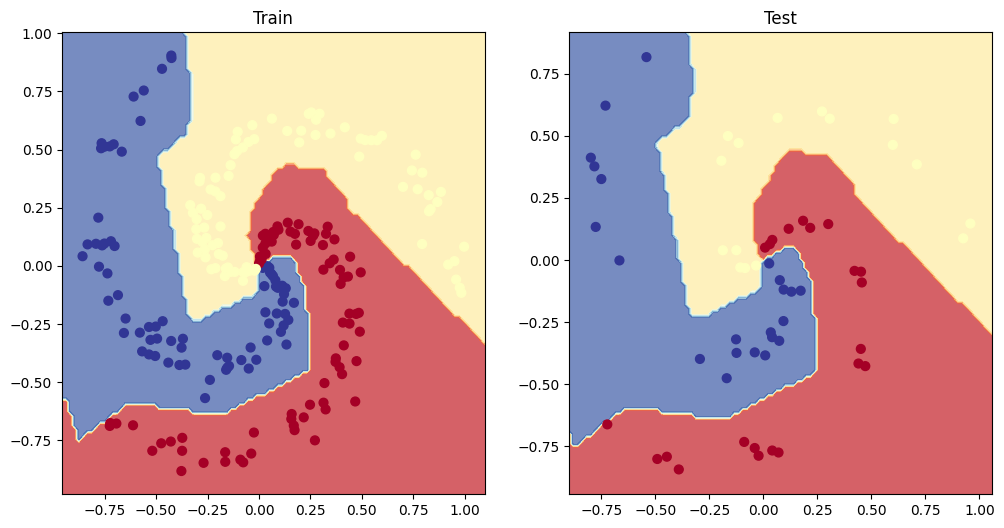

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)